## 0. Import Libraries

### Built-in Libraries

In [1]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt

### Individual Libraries

In [2]:
from util import data_preprocessing as dp
from util import technical_indicators as ta
from util import customized_indicator as ca

### 3rd party libraries

In [3]:
# useful tool
import numpy as np
import pandas as pd
import pandas_ta as pd_ta
import matplotlib.pyplot as plt

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

## 1. Data Preprocessing

### Select Time Range

In [4]:
# select data
root = "../data/"
df_txf = pd.read_csv(root + "TXF1-Minute-Trade_2.txt")
df_txf["symbols"] = "TXF1"
# df_txf["symbols"] = "EXF1"
df_all_list = [df_txf]

# select init data range
start_date = datetime.datetime(2003, 1, 2).date()
end_date = datetime.datetime(2023, 4, 26).date()
start_time = datetime.time(8,45,0)
end_time = datetime.time(23,59,0)
for i in range(len(df_all_list)):
    df = df_all_list[i]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d').dt.date
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

    condition_date_range = (df["Date"] >= start_date) & (df["Date"] <= end_date)
    condition_time_range = (df["Time"] >= start_time) & (df["Time"] <= end_time)
    df= df[condition_date_range & condition_time_range]
    df = df.reset_index(drop=True)
    df_all_list[i] = df


### Remove NaN

In [5]:
# handle missing data
for i in range(len(df_all_list)):
    df = df_all_list[i]
    df['DateTime'] = pd.to_datetime(df.Date.astype(str)+' '+df.Time.astype(str))
    grouped = df.groupby("Date")
    new_groups = []
    for name,group in grouped:
        group.index = group["DateTime"]
        all_minutes = pd.date_range(group.index.min(), group.index.max(), freq='T')
        group = group.reindex(all_minutes)
        group['Date'] = group.index.date
        group['Time'] = group.index.time
        group['DateTime'] = group.index
        group["symbols"] = group["symbols"][0]        
        group[['Open', "High", "Low", "Close", "TotalVolume"]] = group[['Open', "High", "Low", "Close", "TotalVolume"]].interpolate()
        new_groups.append(group)
    df = pd.concat(new_groups)
    df_all_list[i] = df

### Select Final Time Range

In [6]:
# select final time range
start_date = datetime.datetime(2003, 1, 2).date()
end_date = datetime.datetime(2023, 4, 26).date()
start_time = datetime.time(8,45,0)
end_time = datetime.time(13,45,0)
for i in range(len(df_all_list)):
    df = df_all_list[i]
    condition_date_range = (df["Date"] >= start_date) & (df["Date"] <= end_date)
    condition_time_range = (df["Time"] >= start_time) & (df["Time"] <= end_time)
    df= df[condition_date_range & condition_time_range]
    df = df.reset_index(drop=True)
    if df.isnull().values.any() == True:
        print("Intepolated NaN value Failed!")
    df = df[(df["Date"] != datetime.date(2019, 4, 2)) & (df["Date"] != datetime.date(2022, 10, 5)) & (df["Date"] != datetime.date(2017, 10, 30)) & (df["Date"] != datetime.date(2018, 12, 22))]
    df_all_list[i] = df

    
for item in df_all_list:
    if len(item[item.isnull().any(axis=1)]) != 0:
        print("[ERROR] nan value exists!")
    
df_txf = df_all_list[0]

### Time Period Convert

In [7]:
df = df_txf
grouped = df.groupby("Date")
features = [x for x in df.columns if not x.endswith("Time")]
df_day = pd.DataFrame(columns=features)

idx = 0
MIN_VAL = 0.000001
for name, group in grouped:
    Date = group["Date"].iloc[0]
    Open = group["Open"].iloc[0] + MIN_VAL*1
    High = group["High"].max() + MIN_VAL*2
    Low = group["Low"].min() + MIN_VAL*3
    Close = group["Close"].iloc[-1] + MIN_VAL*4
    Volume = group["TotalVolume"].sum()
    symbols = group["symbols"].iloc[0]
    df_day.loc[idx] = [Date, Open, High, Low, Close, Volume, symbols]
    idx += 1
df_txf = df_day.copy()

## 2. Features Extraction

### Prepare Input

In [8]:
group = df_txf
group["Volatility_1"] = 100*(group['High'] - group['Low']) / group['Low']
group["Volatility_2"] = 100*(group['High'].shift(1) - group['Low'].shift(1)) / group['Low'].shift(1)
group["Volatility_3"] = 100*(group['High'].shift(2) - group['Low'].shift(2)) / group['Low'].shift(2)
group["Volatility_7"] = 100*(group['High'].shift(6) - group['Low'].shift(6)) / group['Low'].shift(6)
group["Volatility_15"] = 100*(group['High'].shift(14) - group['Low'].shift(14)) / group['Low'].shift(14)
group["trend"] = 100*(group['High'] - group['Open']) / group['Open']

# calculate n bar current ratio close and volume
time_range = [2, 3, 7, 15]
for item in time_range:
    group = ca.get_n_bar_current_ratio_close(group, item)
    group = ca.get_n_bar_current_ratio_volume(group, item)

# calculate n bar continuous features
time_range = [2, 3]
for item in time_range:
    group = ca.get_is_continuous_n_red_bar(group, item)
    group = ca.get_is_continuous_n_green_bar(group, item)
    group = ca.get_is_continuous_highest_n_bar(group, item)
    group = ca.get_is_continuous_lowest_n_bar(group, item)

df_txf = group

### Prepare Output

In [9]:
df = df_txf
df["labels"] = df["Volatility_1"].shift(-1)
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

4991


### Train/Test Split

In [10]:
columns = [x for x in df.columns if not (x.endswith("Time")  or x in ["Date", "symbols", "labels", "Open", "High", "Low", "Close", "TotalVolume"])]
features = df[columns]
labels = np.where(df['labels'] > 1, 1, 0 )
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=False)

## 3. Builfl Model

### Model Training

In [11]:
#create individual models
logreg_model = LogisticRegression(solver="liblinear")
dt_model = DecisionTreeClassifier(max_depth=5)
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier(n_estimators=200)
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()
gdb_model = GradientBoostingClassifier()
knn_model = KNeighborsClassifier()

ens_model = VotingClassifier(estimators=[('knn', knn_model), ('gdb', gdb_model), ('lgbm', lgbm_model), ('xgb', xgb_model), ('lr', logreg_model), ('svm', svm_model), ('rf', rf_model)], voting='soft')
ens_model.fit(X_train, y_train)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('gdb', GradientBoostingClassifier()),
                             ('lgbm', LGBMClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=N...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lr', LogisticRegression(solver='liblinear')),
                             ('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(n_estimators=200))],
                 voting='soft')

### Model Prediction

In [12]:
ens_y_pred = ens_model.predict(X_test)
print(classification_report(y_test, ens_y_pred))
print("Ensemble Model accuracy: %.4f" % (accuracy_score(y_test, ens_y_pred)))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       501
           1       0.71      0.70      0.70       498

    accuracy                           0.71       999
   macro avg       0.71      0.71      0.71       999
weighted avg       0.71      0.71      0.71       999

Ensemble Model accuracy: 0.7057


### Model Evaluation

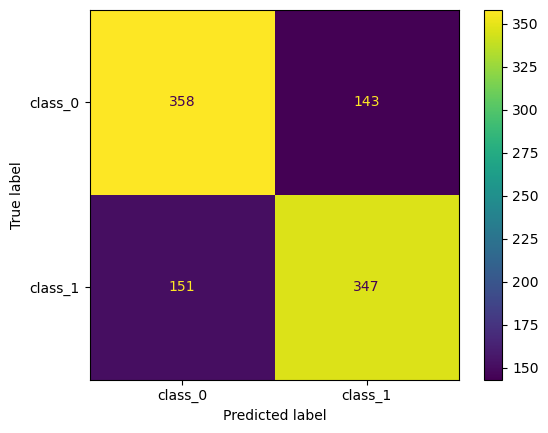

In [13]:
confusion_matrix = metrics.confusion_matrix(y_test, ens_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["class_0", "class_1"])
cm_display.plot()
plt.show()

Text(0.5, 0, 'xgb classifier Feature Importance')

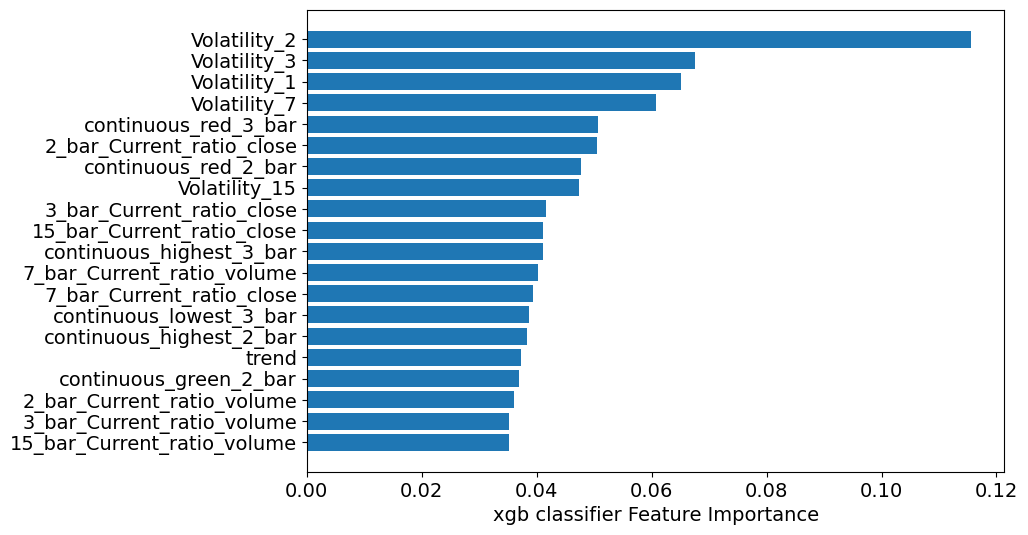

In [14]:
plt.rcParams.update({'figure.figsize': (9.0, 6.0)})
plt.rcParams.update({'font.size': 14})

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

sorted_idx = xgb.feature_importances_.argsort()[-20:]
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("xgb classifier Feature Importance")

<Figure size 2000x700 with 0 Axes>

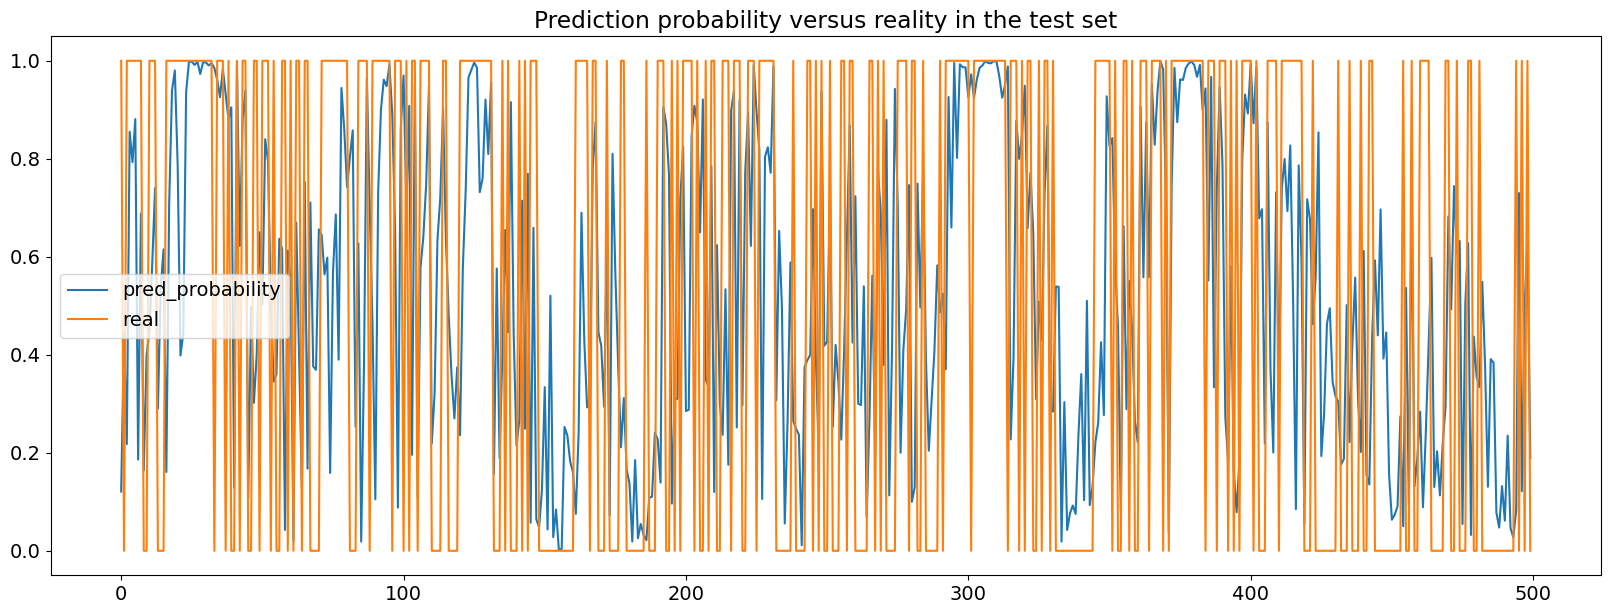

In [15]:
plt.figure(figsize=(20,7))
proba = xgb.predict_proba(X_test)[:,1]

start = len(X_test) //2
end = len(X_test) //1
x = proba[start:end]
y = y_test[start:end]


plt.figure(figsize=(20,7))
plt.plot(np.arange(len(x)), x, label='pred_probability')
plt.plot(np.arange(len(y)), y, label='real' );
plt.title('Prediction probability versus reality in the test set');
plt.legend();
plt.show();